#Mental Health Exploring
https://www.kaggle.com/competitions/playground-series-s4e11/overview

In [2]:
!pip install CATBoost
!pip install optuna
!pip install lightgbm
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.0 MB/s eta 0:00:00


#Create the training and test dataset

---



In [3]:
#1. Download the data from kaggle
import pandas as pd
url ="https://github.com/alamurm/pixelTest/blob/main/case_study/MentalHealthExploring/Dataset"
dsTrain = pd.read_csv( url + "/train.csv?raw=True")
dsTest=pd.read_csv(url+"/test.csv?raw=True")
TARGET = 'Depression'

#EDA - Exploratory Data Analysis

---



In [4]:
dsTrain.shape
dsTrain.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [5]:
#2. Exploratory data analysis

#Find the features with missing values
print(dsTrain.isnull().sum())

#Analyse the values in the demographics features
print (dsTrain['Age'].value_counts())
print(dsTrain['City'].value_counts())
print(dsTrain['Gender'].value_counts())
print(dsTrain['Profession'].value_counts())
print(dsTrain['Working Professional or Student'].value_counts())

#Aanlayse the values in psychosocial features
print(dsTrain['Financial Stress'].value_counts())
print(dsTrain['Job Satisfaction'].value_counts())
print(dsTrain['Study Satisfaction'].value_counts())
print(dsTrain['Academic Pressure'].value_counts())
print(dsTrain['Work Pressure'].value_counts())
print(dsTrain['Family History of Mental Illness'].value_counts())
print(dsTrain['Have you ever had suicidal thoughts ?'].value_counts())
#Analyse the lifestyle features
print(dsTrain['Sleep Duration'].value_counts())
print(dsTrain['Dietary Habits'].value_counts())
print(dsTrain['Degree'].value_counts())
print(dsTrain['CGPA'].value_counts())
print(dsTrain['Work/Study Hours'].value_counts())

#Analyse age group in order with suicidal thoughts and depression
res = dsTrain[dsTrain['Have you ever had suicidal thoughts ?']=='Yes'].groupby(by = ['Age'])
print(res['Age'].value_counts().sort_values(ascending=False))

#Analyse the class imbalance
classCount= dsTrain['Depression'].value_counts()
print(f'class imbalance ratio , majority over minority class : {round(classCount[0]/classCount[1],2)} : 1')
classCount.to_frame().T

print(dsTrain[dsTrain['Job Satisfaction'].notnull() &
        dsTrain['Study Satisfaction'].notnull()])

# F14 No merging conflicts with the pressure columns
dsTrain[dsTrain['Academic Pressure'].notnull() &
        dsTrain['Work Pressure'].notnull()]

#F15 21 records have both values null for Work Pressure and Academic Pressure
filtered = dsTrain[(dsTrain['Work Pressure'].isnull()) & (dsTrain['Academic Pressure'].isnull())]
print (filtered)

#F16 15 records have both values null for Job Satisfaction and Study Satisfaction
filtered = dsTrain[(dsTrain['Job Satisfaction'].isnull()) & (dsTrain['Study Satisfaction'].isnull())]
print (len(filtered))
print(dsTrain.isnull().sum())


id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64
Age
56.0    5246
49.0    50

Findings from EDA
1. Id , name column seems irrelevant for our analysis
2. There are around 98 cities 64 professions with high cardinality  features
3. pressure & satisfaction cols has scale from 1 to 5
4. Sleep duration, Dietary habits, Degree has noise
5. Age group with higher risk , 18 - 32!!!
6. job satisfaction and work satisfaction  could be merged
7. Academic pressure and work pressure could be merged
8. There is no class imbalance as the the ratio is 1:4.5 for the target feature , Depression


In [6]:
#Intialize Variables
CAT_FEATURES=['Gender', 'City', 'Working Professional or Student', 'Profession',
            'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
              'Family History of Mental Illness',
              'Academic Pressure', 'Work Pressure',
              'Study Satisfaction','Job Satisfaction', 'Financial Stress']
NUM_FEATURES=['Age','CGPA','Work/Study Hours']

FEATURES_WITH_MORE_UNIQUE_VALUES =[]
FEATURES_WITH_LESS_UNIQUE_VALUES =[]
for col in CAT_FEATURES:
    if (len(dsTrain[col].unique()) > 6 ):
      FEATURES_WITH_MORE_UNIQUE_VALUES.append(col)
    else :
      FEATURES_WITH_LESS_UNIQUE_VALUES.append(col)
print(FEATURES_WITH_MORE_UNIQUE_VALUES)
print(FEATURES_WITH_LESS_UNIQUE_VALUES)

#Handle noises in the data
DIETARY_HABITS=['Healthy','Moderate','Unhealthy']


['City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']
['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Financial Stress']


#Visual Insights

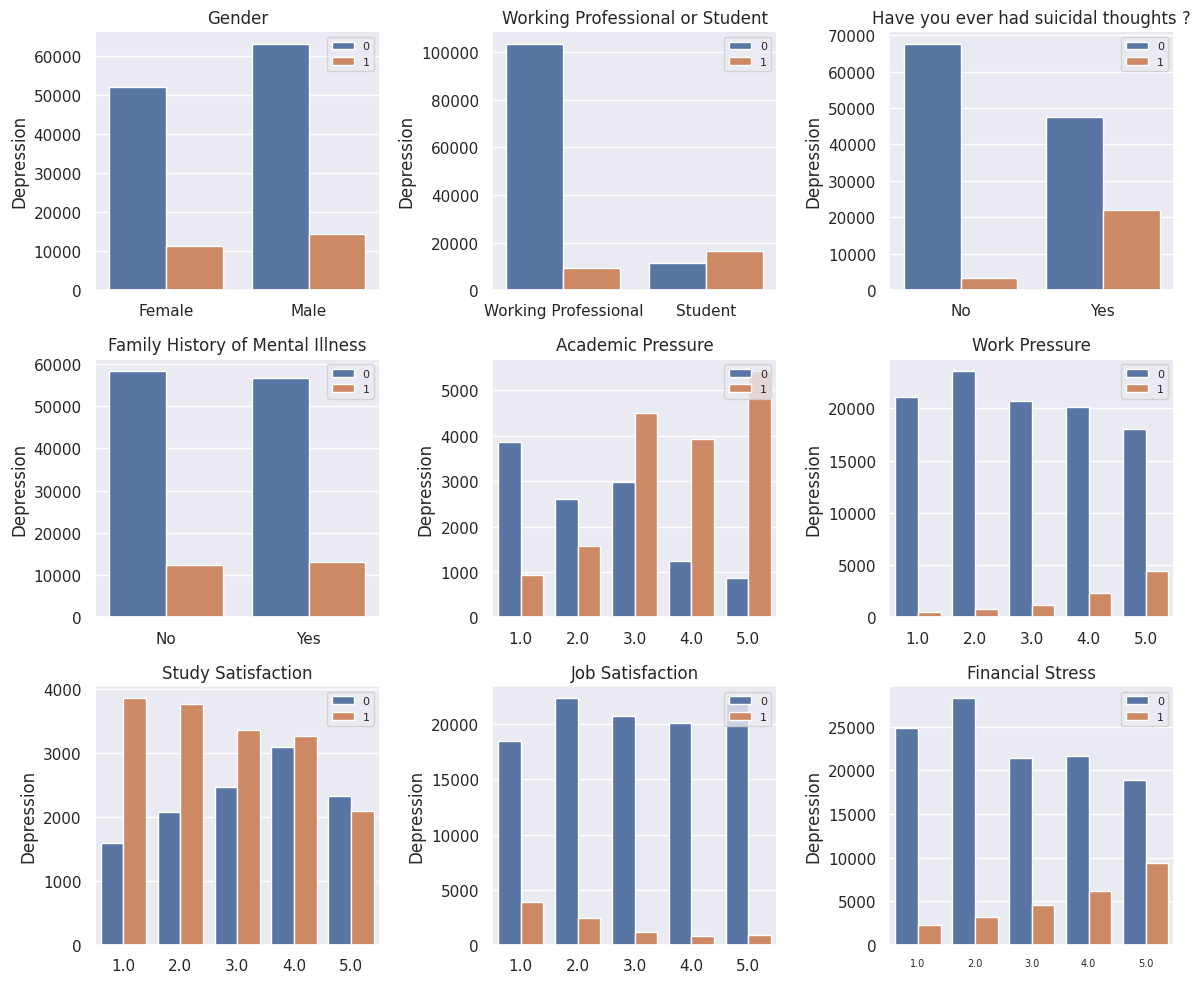

In [ ]:
#2 Visual insights
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
fig, ax =plt.subplots(3,3, figsize=(12,10))
fig.subplots_adjust(wspace=0.3, hspace=0.7)
#Columns to analyse for visual insights

for col, subplot in zip(FEATURES_WITH_LESS_UNIQUE_VALUES, ax.flatten()):

  sns.countplot(ax=subplot, data =dsTrain, x=col, hue='Depression')
  subplot.legend(loc=1, prop={'size': 8})
  subplot.title.set_text(col )
  subplot.set_ylabel(TARGET)
  subplot.set_xlabel('')
  plt.xticks(fontsize=7)

plt.tight_layout()
plt.show()


Visual insights contd...


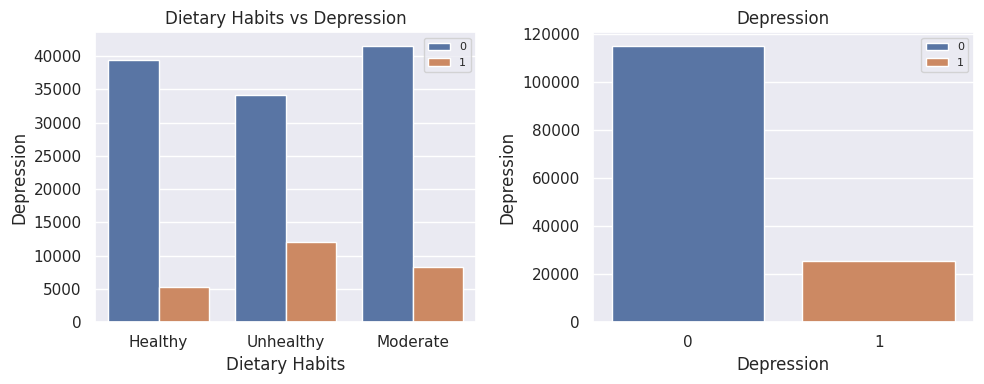

In [ ]:
#Hanlde noises in the data
DIETARY_HABITS=['Healthy','Moderate','Unhealthy']
filteredData = dsTrain.loc[dsTrain['Dietary Habits'].isin(DIETARY_HABITS)]
fig, ax =plt.subplots(1,2, figsize=(10,4))

fig.subplots_adjust(wspace=2.0)
subplot = sns.countplot( ax= ax[0],data=filteredData, x='Dietary Habits', hue='Depression')
subplot.legend(loc=1, prop={'size': 8})
subplot.title.set_text('Dietary Habits' + ' vs ' + TARGET)
subplot.set_ylabel(TARGET)

subplot = sns.countplot( ax= ax[1],data=filteredData, x=TARGET, hue='Depression')
subplot.legend(loc=1, prop={'size': 8})
subplot.title.set_text(TARGET)
subplot.set_ylabel(TARGET)

plt.tight_layout()
plt.show()


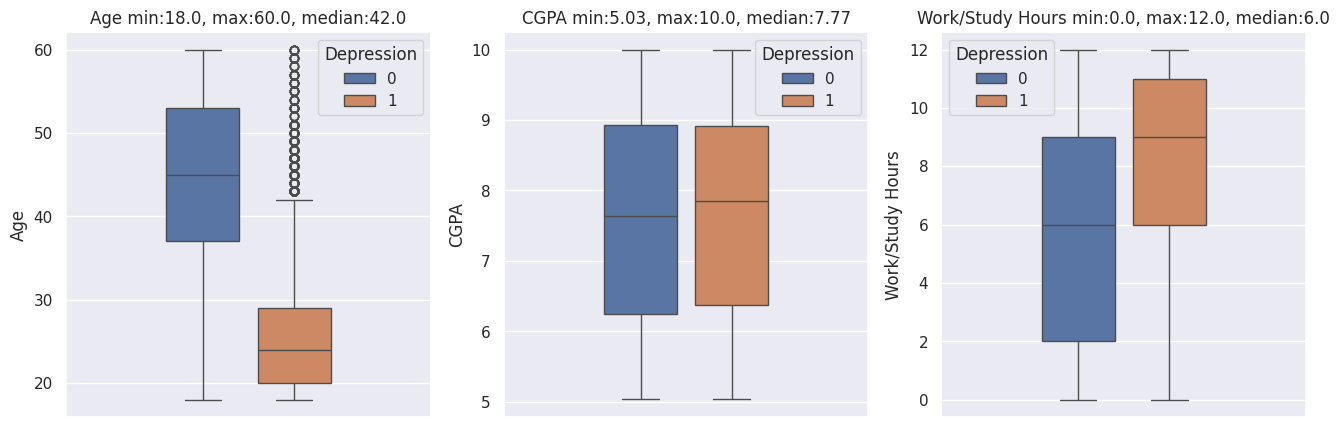

In [ ]:
#Box plots for numerical features in realtion to the target
fig, ax =plt.subplots(1,3, figsize=(16,5))

for col, subplot in zip(NUM_FEATURES, ax.flatten()):
  sns.boxplot(data=dsTrain,y= col , hue = TARGET, ax=subplot, width=0.5, gap=0.2)
  subplot.set_title(f'{col} min:{dsTrain[col].min()}, max:{dsTrain[col].max()}, median:{dsTrain[col].median()}')

plt.show()

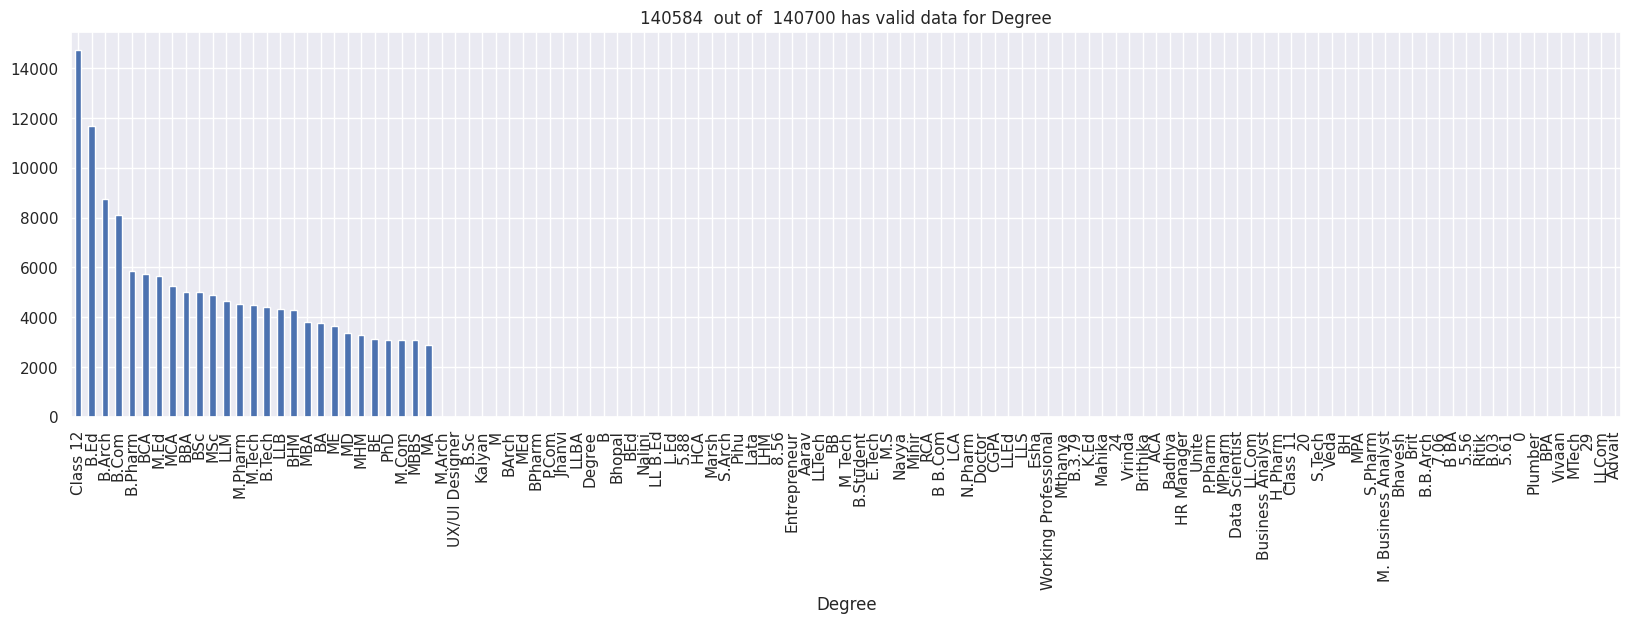

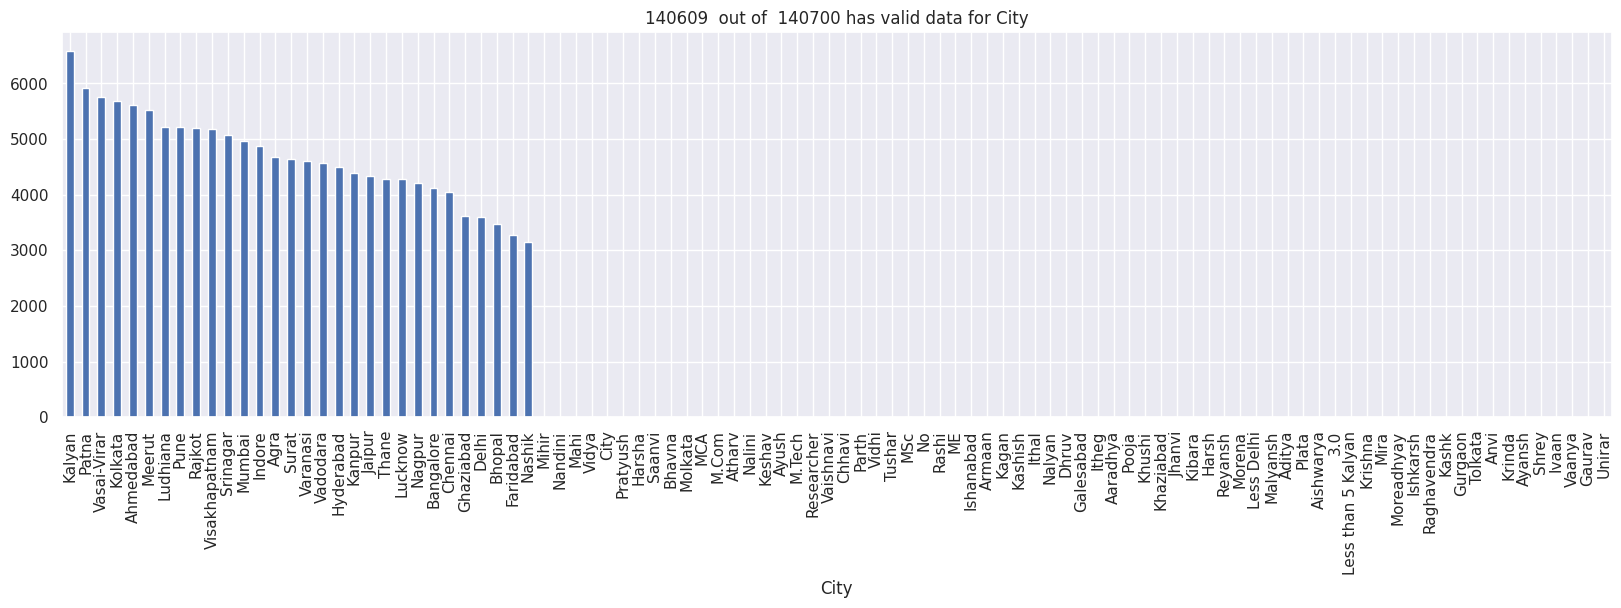

In [ ]:
#Bar plots representing the high cardinality categorical features
grps =dsTrain.groupby("Degree").filter(lambda x: len(x) > 5)
heading = f'{len(grps)}  out of  {len(dsTrain)} has valid data for Degree'
fig , ax = plt.subplots(figsize=(20, 5))
dsTrain['Degree'].value_counts().plot(kind='bar', y='Degree', x='count')
plt.title(heading)
plt.show()


grps =dsTrain.groupby("City").filter(lambda x: len(x) > 5)
heading = f'{len(grps)}  out of  {len(dsTrain)} has valid data for City'
fig , ax = plt.subplots(figsize=(20, 5))
dsTrain['City'].value_counts().plot(kind='bar', y='City', x='count')
plt.title(heading)
plt.show()


#Split the data to train and validation

In [7]:
#Split train and val data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#labels removed from training data
y=dsTrain[TARGET]
X=dsTrain.drop(TARGET, axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=40,stratify=y)


#Data Preprocessing

---



In [8]:
import numpy as np
#3. This function processes and prepares the data ready for ML algorithm
def wrangle(ds, catFeaturesAsStr):



  ds['Pressure'] = np.where(ds['Working Professional or Student']=='Student',
                    np.where(ds['Academic Pressure'].notnull(), ds['Academic Pressure'],ds['Work Pressure']),
                    ds['Work Pressure'])
  ds['Pressure'] = np.where(ds['Working Professional or Student']!='Student',
                    np.where(ds['Work Pressure'].notnull(), ds['Work Pressure'],ds['Academic Pressure']),
                    ds['Academic Pressure'])
  ds['Satisfaction'] = np.where(ds['Working Professional or Student']=='Student',
                    np.where(ds['Study Satisfaction'].notnull(), ds['Study Satisfaction'],ds['Job Satisfaction']),
                    ds['Job Satisfaction'])
  ds['Satisfaction'] = np.where(ds['Working Professional or Student']!='Student',
                    np.where(ds['Job Satisfaction'].notnull(), ds['Job Satisfaction'],ds['Study Satisfaction']),
                    ds['Study Satisfaction'])
  dsRet= ds.drop(["id", "Name", "Work Pressure", "Academic Pressure", "Job Satisfaction","Study Satisfaction" ], axis= 1)
  CAT_FEATURES=list(dsRet.select_dtypes(['object']).columns)
  CAT_FEATURES.append('Pressure')
  CAT_FEATURES.append('Satisfaction')

  if catFeaturesAsStr :
    for col in CAT_FEATURES:
      dsRet[col]=dsRet[col].astype(str)
  else :
    for col in CAT_FEATURES:
      dsRet[col]=dsRet[col].astype('category')

  catFeatureIndices = [dsRet.columns.get_loc(col) for col in CAT_FEATURES]
  return dsRet, catFeatureIndices



In [9]:
#Preprocess Train data
processed_train, catFeaureIndices=wrangle(X_train, True)
print("Processed Training")
processed_val,catFeatureIndices=wrangle(X_val,True)
print("Processed Validation")

Processed Training
Processed Validation


In [10]:
# Datastructure to store the results from different models
trainedModel=[]

ALGORITHMS_TO_EVALUATE=['Catboost','LGBM']

RECALL = 'recall'
PRECISION= 'precision'
F1SCORE = 'f1-score'
ACCURACY= 'Accuracy'
TRAIN_ACCURACY = 'tAccuracy'

METRICS_TO_COMPARE = [ACCURACY, TRAIN_ACCURACY, PRECISION, RECALL,F1SCORE ]
metricDict={}
for metric in METRICS_TO_COMPARE:
  metricDict[metric]=0.0

metricsData=[]
for alg in ALGORITHMS_TO_EVALUATE:
    metricsData.append(metricDict)
print(metricsData)

modelMetrics_df= pd.DataFrame(metricsData, index=ALGORITHMS_TO_EVALUATE )
print(modelMetrics_df)


[{'Accuracy': 0.0, 'tAccuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, {'Accuracy': 0.0, 'tAccuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}]
          Accuracy  tAccuracy  precision  recall  f1-score
Catboost       0.0        0.0        0.0     0.0       0.0
LGBM           0.0        0.0        0.0     0.0       0.0


#Train the model with CATBoost

In [11]:
from catboost import CatBoostClassifier, Pool

trainingPool = Pool(processed_train, label=y_train, cat_features=catFeatureIndices)
valPool = Pool(processed_val, label=y_val,cat_features=catFeatureIndices)

model = CatBoostClassifier()
model.fit(trainingPool)
trainedModel.append(model)


Learning rate set to 0.073133
0:	learn: 0.5694261	total: 255ms	remaining: 4m 14s
1:	learn: 0.4791951	total: 404ms	remaining: 3m 21s
2:	learn: 0.4115104	total: 588ms	remaining: 3m 15s
3:	learn: 0.3611669	total: 771ms	remaining: 3m 12s
4:	learn: 0.3241768	total: 937ms	remaining: 3m 6s
5:	learn: 0.2940658	total: 1.1s	remaining: 3m 2s
6:	learn: 0.2718969	total: 1.29s	remaining: 3m 2s
7:	learn: 0.2541699	total: 1.43s	remaining: 2m 57s
8:	learn: 0.2395063	total: 1.6s	remaining: 2m 55s
9:	learn: 0.2275788	total: 1.76s	remaining: 2m 54s
10:	learn: 0.2183433	total: 1.92s	remaining: 2m 52s
11:	learn: 0.2114904	total: 2.1s	remaining: 2m 52s
12:	learn: 0.2047811	total: 2.29s	remaining: 2m 53s
13:	learn: 0.1997895	total: 2.43s	remaining: 2m 51s
14:	learn: 0.1959979	total: 2.59s	remaining: 2m 50s
15:	learn: 0.1917119	total: 2.75s	remaining: 2m 48s
16:	learn: 0.1886463	total: 2.91s	remaining: 2m 48s
17:	learn: 0.1851809	total: 3.08s	remaining: 2m 48s
18:	learn: 0.1830536	total: 3.24s	remaining: 2m 47

#Train the model with LGBM

In [12]:
from category_encoders.cat_boost import CatBoostEncoder

encoder = CatBoostEncoder()
# Fit the encoder on the training data
encoder.fit(processed_train, y_train)
# Encode categorical variables
X_train_encoded = encoder.transform(processed_train)
X_val_encoded = encoder.transform(processed_val)


In [13]:
from lightgbm import LGBMClassifier

model= LGBMClassifier(importance_type='gain')
model.fit(X=X_train_encoded, y = y_train)
trainedModel.append(model)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17897, number of negative: 80593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 98490, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181714 -> initscore=-1.504779
[LightGBM] [Info] Start training from score -1.504779


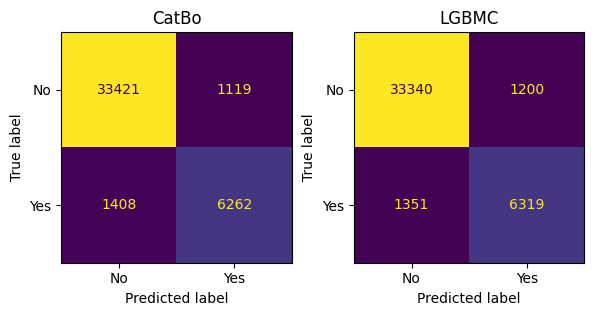

          Accuracy  tAccuracy  precision  recall  f1-score
Catboost     94.01      94.58      84.84   81.64     83.21
LGBM         93.96      94.40      84.04   82.39     83.20


In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

#Display clasification metrics
def classificationMetrics(trainedModel):
  fig,ax=plt.subplots(1,len(trainedModel),figsize=(6,6))
  fig.subplots_adjust(wspace=0.5)
  fig.tight_layout()
  for model, subplot in zip(trainedModel, ax.flatten()):


    searchIndex='Catboost'
    if isinstance(model, CatBoostClassifier):
      searchIndex='Catboost'
      pred= model.predict(processed_val)
      accuracy = round(accuracy_score(y_val, pred)*100,2)
      tpred= model.predict(processed_train)
      taccuracy = round(accuracy_score(y_train, tpred)*100,2)
    elif isinstance(model, LGBMClassifier):
      pred= model.predict(X_val_encoded)
      accuracy = round(accuracy_score(y_val, pred)*100,2)
      tpred= model.predict(X_train_encoded)
      taccuracy = round(accuracy_score(y_train, tpred)*100,2)
      searchIndex = 'LGBM'
    report= classification_report(y_val, pred, output_dict=True)
    modelMetrics_df.loc[searchIndex, ACCURACY] = accuracy
    modelMetrics_df.loc[searchIndex, PRECISION] = round(report['1'][PRECISION] *100,2)
    modelMetrics_df.loc[searchIndex, RECALL] = round(report['1'][RECALL] *100,2)
    modelMetrics_df.loc[searchIndex, F1SCORE] = round(report['1'][F1SCORE] *100,2)
    modelMetrics_df.loc[searchIndex, TRAIN_ACCURACY] = taccuracy
    cmatrix =confusion_matrix(y_val, pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['No', 'Yes'])
    cm_display.plot(ax=subplot, colorbar=False)
    subplot.title.set_text(type(model).__name__[:5])
  plt.show()
  #print('Baseline accuracy : ', round(baseline_accuracy*100,2))
  print(modelMetrics_df)

classificationMetrics(trainedModel)

#Cross validation to evaluate the model

In [ ]:
from catboost import cv, Pool

dataPool= Pool(data = processed_train, label=y_train, cat_features=catFeatureIndices)
params={'verbose': True,
        'loss_function': 'Logloss',
         'metrics' :'accuracy'}

cvScores= cv(dataPool,fold_count=10,stratified='y', as_pandas=True, params=params)

print(f'Accuracy with crossvalidation with cat boost  {cvScores.mean()*100}')


In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import cross_val_score
model=lgbm.LGBMClassifier(importance_type='gain')
cvScore = cross_val_score(model, X_train_encoded, y_train,cv=10)
print(f'Accuracy with crossvalidation with LGBM  {cvScore.mean()*100}')

In [ ]:
#Function to calculate the auc
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
lineWidth =2
def calculateROC(models):
  for mdl in models:
    lineWidth=lineWidth-0.5
    if isinstance(mdl, LGBMClassifier):
      Y_prob=mdl.predict_proba(X_val_encoded)
    else :
      Y_prob=mdl.predict_proba(processed_val)

    fpr, tpr, thresold =roc_curve(y_val, Y_prob[:,1])
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr, tpr, label =f'{type(model)} with roc_auc{roc_auc:.2f}', linewidth =lineWidth)

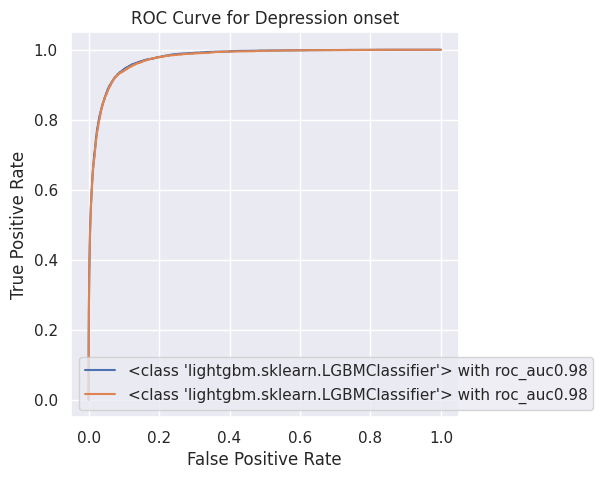

In [ ]:
#5 plot the roc
plt.figure(figsize=(5,5), dpi=100)
calculateROC(trainedModel)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Depression onset')
plt.legend()
plt.show()

#Hyperparameter tunning with Optuna

In [ ]:
import optuna
def Objective_lgbm(trial):
  param_grid = {
    'learning_rate': trial.suggest_float('learning_rate',0.01, 0.1),
    'n_estimators': 100,
    'importance_type':'gain'
  }
  model= lgbm.LGBMClassifier(**param_grid)
  model.fit(X=X_train_encoded, y  = y_train)
  pred=model.predict(X_train_encoded)
  report= classification_report(y_train, pred, output_dict=True)
  print(report)
  print ('Report for testing data')
  pred=model.predict(X_val_encoded)
  accuracy = accuracy_score(y_val,pred)
  return accuracy


In [ ]:
study = optuna.create_study(directions=['maximize'])
study.optimize(Objective_lgbm, n_trials=30)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best Accuracy:', study.best_value)

Best hyperparameters: {'learning_rate': 0.06239627755928075}
Best Accuracy: 0.9385690594645818


In [ ]:
#Optuna has a objecctive function and the number of trials involved as param
#A study with the objective is created which focuses on optimizing the
#objective functions return value, which is accracy in this case.
import optuna
from sklearn.metrics import classification_report
def Objective(trial):
  params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain'])
    }
  trainingPool = Pool(X_train, label=y_train, cat_features=catFeatureIndices)
  valPool = Pool(X_val, label=y_val,cat_features=catFeatureIndices)

  catModel= CatBoostClassifier(**params, silent=True)
  catModel.fit(trainingPool)
  pred=catModel.predict(valPool)
  report= classification_report(y_val, pred, output_dict=True)
  f1score=report['0']['f1-score'] #Focus on false nagative
  accuracy = accuracy_score(y_val,pred)
  return accuracy

study = optuna.create_study(directions=['maximize'])
study.optimize(Objective, n_trials=30)

In [ ]:

print('Best hyperparameters:', study.best_params)
print('Best Accuracy:', study.best_value)

#Find the optimal thresold with ROC

In [ ]:
print(model.get_probability_threshold())
model.set_probability_threshold(0.5)
pred=model.predict(valPool)
accuracy = accuracy_score(y_val,pred)
print(round(accuracy*100,2))
pred = model.predict(trainingPool)
accuracy = accuracy_score(y_train,pred)
print("TRainning accuracy", accuracy)

#Predict for test data

In [ ]:
#Prediction for test data
dsTest.info()
processed_Test = wrangle(dsTest)
if LGBM:
  processed_Test =encoder.transform(processed_Test)

ypred=model.predict(processed_Test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             69168 non-null  object 
 7   Academic Pressure                      18767 non-null  float64
 8   Work Pressure                          75022 non-null  float64
 9   CGPA                                   18766 non-null  float64
 10  Study Satisfaction                     18767 non-null  float64
 11  Jo

#predictions in a csv file for submission

In [ ]:

submission = pd.DataFrame(dsTest['id'])
submission[TARGET]=ypred
submission.to_csv('result.csv',index= False)


#Feature Importance

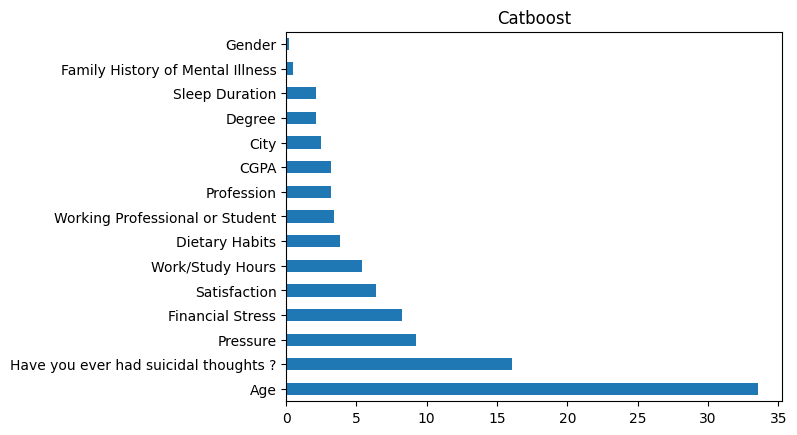

<Axes: title={'center': 'LGBM'}>

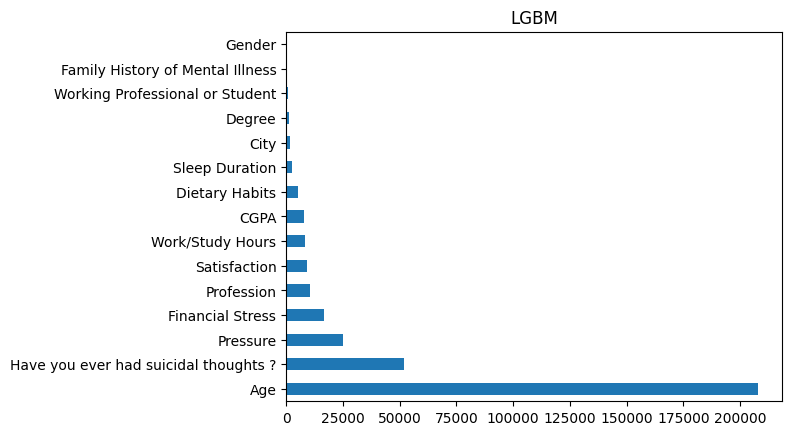

In [21]:
features = pd.Series(trainedModel[0].feature_importances_, index = processed_train.columns)

#features.nlargest(10).plot.barh(y=features.index)
features.sort_values(ascending=False).plot.barh(y=features.index)
plt.title('Catboost')
plt.show()
features = pd.Series(trainedModel[1].feature_importances_, index = processed_train.columns)
plt.title('LGBM')
#features.nlargest(10).plot.barh(y=features.index)
features.sort_values(ascending=False).plot.barh(y=features.index)